<a href="https://colab.research.google.com/github/NLinh-Tran/Lending-Club-Analysis/blob/main/Lending_Club_Logistic_Regression_(Removed_'policy_code'%2C_Tuned_'class_weight').ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
wordsforthewise_lending_club_path = kagglehub.dataset_download('wordsforthewise/lending-club')

print('Data source import complete.')


Data source import complete.


In [8]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


# Install PySpark

In [9]:
!pip install PySpark

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import logging
import sys
import os

print('Import Libraries')

Import Libraries


In [11]:
spark = SparkSession.builder                                        \
                    .appName("LendingClubAnalysis")                 \
                    .config("spark.ui.showConsoleProgress","false") \
                    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

In [12]:
accepted_df = spark.read.option("header", True)                                             \
                        .option("inferSchema", True)                                        \
                        .option("multiLine", True)                                          \
                        .option("escape", '"')                                              \
                        .csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz")

rejected_df = spark.read.option("header", True)                                            \
                        .option("inferSchema", True)                                        \
                        .option("multiLine", True)                                          \
                        .option("escape", '"')                                              \
                        .csv("/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz")

# Combined Dataset
* loan_amnt
* emp_length
* dti
* addr_state
* policy_code - REMOVED
* accepted_flag

In [14]:
# Accpeted
accepted_c = accepted_df.withColumn('accepted_flag', lit(1)) \
                         .select('loan_amnt', 'emp_length', 'dti', 'addr_state', 'accepted_flag')

# Rejected
rejected_c = rejected_df.withColumnRenamed('Amount Requested', 'loan_amnt') \
                         .withColumnRenamed('Employment Length', 'emp_length') \
                         .withColumnRenamed('State', 'addr_state') \
                         .withColumn('dti', regexp_replace(col('Debt-To-Income Ratio'), '%', '').cast('double')) \
                         .withColumn('accepted_flag', lit(0)) \
                         .select('loan_amnt', 'emp_length', 'dti', 'addr_state', 'accepted_flag')

In [15]:
# Combine 2 datsets
combined_df = accepted_c.union(rejected_c)

combined_df = combined_df.withColumn('emp_length_years',
                       when(col('emp_length') == '< 1 year', 0)
                       .when(col('emp_length') == '1 year', 1)
                       .when(col('emp_length') == '2 years', 2)
                       .when(col('emp_length') == '3 years', 3)
                       .when(col('emp_length') == '4 years', 4)
                       .when(col('emp_length') == '5 years', 5)
                       .when(col('emp_length') == '6 years', 6)
                       .when(col('emp_length') == '7 years', 7)
                       .when(col('emp_length') == '8 years', 8)
                       .when(col('emp_length') == '9 years', 9)
                       .when(col('emp_length') == '10+ years', 10)
                       .when(col('emp_length').isNull(), -1)
                       .otherwise(-1))

combined_df = combined_df.drop('emp_length')

# Handle Null values

In [16]:
from pyspark.sql.functions import col, sum as spark_sum

# Drop'loan_amnt' and 'dti' Null values

combined_df.dropna(subset=['loan_amnt', 'dti']) \
           .select([
    spark_sum(col(c).isNull().cast("int")).alias(c)
    for c in combined_df.columns
]).toPandas()

,loan_amnt,dti,addr_state,accepted_flag,emp_length_years
0,0,0,22,0,0


In [17]:
combined_df = combined_df.dropna(subset = ['loan_amnt', 'dti']) \
                         .fillna('unknown', subset = ['addr_state'])

combined_df.count()

29907698

# Encode Categorical Variables

In [18]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

categorical_cols = ["addr_state"]

# StringIndexer — turns strings into numeric category indices
indexers = [
    StringIndexer(inputCol=c, outputCol=c + "_idx", handleInvalid="keep")
    for c in categorical_cols
]

# OneHotEncoder — turns those indices into binary vectors, so there's no ordering
encoders = [
    OneHotEncoder(inputCol=c + "_idx", outputCol=c + "_vec")
    for c in categorical_cols
]

# Assemble Features

* features: contains a single vector of all features per row
* label: the outcome trying to predict

In [19]:
from pyspark.ml.feature import VectorAssembler

feature_cols = ["loan_amnt", "dti", "emp_length_years"] + [c+"_vec" for c in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Split into Train and Test Sets (80:20)
with random_state(seed) = 42

In [20]:
train_df, test_df = combined_df.randomSplit([0.8, 0.2], seed=42)

## Train the Logistic Regression Model

In [22]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

lr = LogisticRegression(featuresCol="features", labelCol="accepted_flag")

pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])
model = pipeline.fit(train_df)

## Coefficients

**Early read**:
* the model relies heavily on 'addr_state'
* 'addr_state_vec_51' = 'unknown' has an extreme coefficient

In [27]:
lr_model = model.stages[-1]

# Numerical features
numerical_cols = ["loan_amnt", "dti", "emp_length_years"]
full_feature_list = numerical_cols.copy()

# Find the encoder that turned 'addr_state' into one-hot vectors
addr_state_encoder = [stage for stage in model.stages if hasattr(stage, 'getOutputCol') and stage.getOutputCol() == 'addr_state_vec'][0]
addr_state_size = addr_state_encoder.categorySizes[0] - 1

full_feature_list.extend([f"addr_state_vec_{i}" for i in range(addr_state_size)])

# Get the list of model coefficients
coef_array = lr_model.coefficients.toArray()

# Check Feature names and Coefficients match
print("Feature names:", len(full_feature_list))
print("Coefficients:", len(coef_array))

# DataFrame
coef_df = pd.DataFrame({
    "feature": full_feature_list,
    "coefficient": coef_array
})
coef_df["abs_coefficient"] = np.abs(coef_df["coefficient"])

# Sort by magnitude
coef_df_sorted = coef_df.sort_values("abs_coefficient", ascending=False)
coef_df_sorted


Feature names: 55
Coefficients: 55


,feature,coefficient,abs_coefficient
54,addr_state_vec_51,-562.324179,562.324179
53,addr_state_vec_50,-1.325493,1.325493
34,addr_state_vec_31,-0.497882,0.497882
2,emp_length_years,0.423262,0.423262
49,addr_state_vec_46,0.360459,0.360459
22,addr_state_vec_19,-0.350072,0.350072
23,addr_state_vec_20,0.275217,0.275217
38,addr_state_vec_35,-0.274285,0.274285
26,addr_state_vec_23,0.267995,0.267995
33,addr_state_vec_30,-0.261423,0.261423


In [35]:
# Get the StringIndexerModel that created addr_state_idx
indexer_model = [stage for stage in model.stages if hasattr(stage, 'labels') and stage.getOutputCol() == 'addr_state_idx'][0]

# Display the labels in index order
for i, label in enumerate(indexer_model.labels):
    print(f"Index {i}: {label}")

Index 0: CA
Index 1: TX
Index 2: FL
Index 3: NY
Index 4: GA
Index 5: PA
Index 6: IL
Index 7: OH
Index 8: NJ
Index 9: NC
Index 10: MI
Index 11: VA
Index 12: MD
Index 13: AZ
Index 14: TN
Index 15: MA
Index 16: IN
Index 17: WA
Index 18: MO
Index 19: AL
Index 20: CO
Index 21: SC
Index 22: LA
Index 23: MN
Index 24: WI
Index 25: CT
Index 26: KY
Index 27: NV
Index 28: OK
Index 29: OR
Index 30: AR
Index 31: MS
Index 32: KS
Index 33: UT
Index 34: NM
Index 35: HI
Index 36: NH
Index 37: RI
Index 38: NE
Index 39: WV
Index 40: DE
Index 41: ID
Index 42: ME
Index 43: MT
Index 44: AK
Index 45: SD
Index 46: DC
Index 47: VT
Index 48: WY
Index 49: ND
Index 50: IA
Index 51: unknown


In [43]:
# Check 'accepted_flag' of 'addr_state' = 'unknown'

combined_df.filter(col('addr_state') == 'unknown') \
           .groupBy('addr_state', 'accepted_flag').count() \
           .orderBy('addr_state', 'accepted_flag').toPandas()

,addr_state,accepted_flag,count
0,unknown,0,22


## Predictions

In [ ]:
predictions = model.transform(test_df)
predictions.select("accepted_flag", "prediction", "probability").show()

+-------------+----------+--------------------+
|accepted_flag|prediction|         probability|
+-------------+----------+--------------------+
|            1|       0.0|[0.92758798737411...|
|            1|       0.0|[0.97444473466070...|
|            1|       0.0|[0.90105312236171...|
|            1|       0.0|[0.95956339248932...|
|            1|       0.0|[0.97180958134171...|
|            1|       0.0|[0.97139126420985...|
|            1|       0.0|[0.91297075336784...|
|            1|       1.0|[0.26122038327142...|
|            1|       1.0|[0.30923657195883...|
|            1|       0.0|[0.97135777641775...|
|            1|       0.0|[0.94738336922379...|
|            1|       0.0|[0.97704737863752...|
|            1|       0.0|[0.62043066410681...|
|            1|       0.0|[0.96440344692830...|
|            1|       0.0|[0.93515204049399...|
|            1|       0.0|[0.95137307417962...|
|            1|       1.0|[0.30528694497263...|
|            1|       1.0|[0.27772576224

## Evaluations

### 1. Classification Report & Confusion Matrix

              precision    recall  f1-score   support

    Rejected       0.95      0.98      0.97   5530396
    Accepted       0.65      0.38      0.48    451987

    accuracy                           0.94   5982383
   macro avg       0.80      0.68      0.72   5982383
weighted avg       0.93      0.94      0.93   5982383



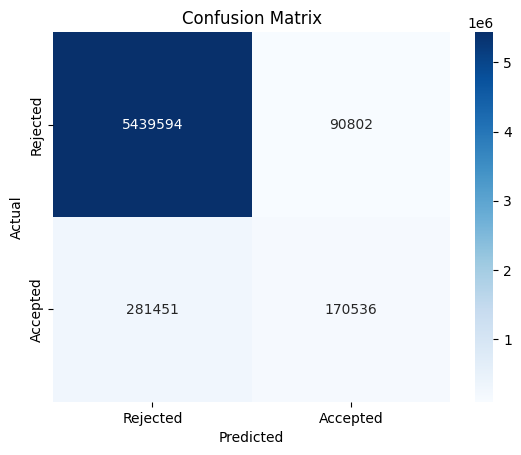

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert prediction results
preds_pd = predictions.select("accepted_flag", "prediction").toPandas()
print(classification_report(preds_pd["accepted_flag"], preds_pd["prediction"], target_names=["Rejected", "Accepted"]))

# Visualize Confusion Matrix
cm = confusion_matrix(preds_pd["accepted_flag"], preds_pd["prediction"])
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Rejected", "Accepted"], yticklabels=["Rejected", "Accepted"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 2. AUC

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="accepted_flag")
print("AUC:", evaluator.evaluate(predictions))

AUC: 0.8634593168599011


In [ ]:
evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})

0.4542234958742374

# Imbalance and Data Leakage Review

### 1. Check the % of accepted_flag in Train and Test set

In [ ]:
# Calculate % in train_df
train_total = train_df.count()

train_percentage = train_df.groupBy('accepted_flag') \
    .count() \
    .withColumnRenamed('count', 'train_count') \
    .withColumn('train_percentage', round((col('train_count') / train_total) * 100, 2))

# Calculate % in test_df
test_total = test_df.count()

test_percentage = test_df.groupBy('accepted_flag') \
    .count() \
    .withColumnRenamed('count', 'test_count') \
    .withColumn('test_percentage', round((col('test_count') / test_total) * 100, 2))

# Overview
split = train_percentage.join(test_percentage, 'accepted_flag')
split = split.orderBy('accepted_flag').toPandas()
split

,accepted_flag,train_count,train_percentage,test_count,test_percentage
0,0,22118345,92.45,5530396,92.44
1,1,1806970,7.55,451987,7.56


### 2. Check for DTI outliers

In [36]:
# Descriptive stats - red flag of data quality issue

combined_df.select("dti").describe().toPandas()

,summary,dti
0,count,29907698
1,mean,133.93524948045496
2,stddev,10133.387168685706
3,min,-1.0
4,max,5.000003149E7


In [37]:
# Loans with invalid dti

combined_df.filter((col('dti') < 0) | (col('dti') > 100)).groupBy('accepted_flag').count().orderBy('accepted_flag').toPandas()

,accepted_flag,count
0,0,2011034
1,1,2563


In [40]:
# DTI > 100

combined_df.filter(col('dti') > 100).groupBy('accepted_flag').count().orderBy('accepted_flag').toPandas()

,accepted_flag,count
0,0,807971
1,1,2561


In [41]:
# DTI < 0

combined_df.filter(col('dti') < 0).groupBy('accepted_flag').count().orderBy('accepted_flag').toPandas()

,accepted_flag,count
0,0,1203063
1,1,2


In [38]:
# DTI outlier distribution

combined_df.withColumn('dti_bucket', floor(col('dti') / 100) * 100) \
           .groupBy('dti_bucket') \
           .count() \
           .filter(col('dti_bucket') >= 100) \
           .orderBy('dti_bucket').toPandas()

,dti_bucket,count
0,100,1664035
1,200,123137
2,300,78550
3,400,50450
4,500,32406
...,...,...
1628,3974400,1
1629,4408800,1
1630,7130300,1
1631,7374800,1


In [39]:
# Descriptive stats after excluding DTI Outliers

combined_df.filter((col('dti') >= 0) & (col('dti') <= 100)).select('dti').describe().toPandas()

,summary,dti
0,count,27894101
1,mean,25.930588497524862
2,stddev,23.81351897625889
3,min,0.0
4,max,100.0


# Tuned 'class_weight'

+-------------+----------+--------------------+
|accepted_flag|prediction|         probability|
+-------------+----------+--------------------+
|            1|       0.0|[0.55272481473090...|
|            1|       0.0|[0.79922423479905...|
|            1|       1.0|[0.46759966015575...|
|            1|       0.0|[0.70964735044378...|
|            1|       0.0|[0.78032171294966...|
|            1|       0.0|[0.77449061688203...|
|            1|       1.0|[0.49538979131023...|
|            1|       1.0|[0.02522195875252...|
|            1|       1.0|[0.03161436010129...|
|            1|       0.0|[0.77425760929925...|
|            1|       0.0|[0.63722485002981...|
|            1|       0.0|[0.81717871785457...|
|            1|       1.0|[0.12053024301347...|
|            1|       0.0|[0.72802213020642...|
|            1|       0.0|[0.57808821229429...|
|            1|       0.0|[0.65337011216181...|
|            1|       1.0|[0.03199076237162...|
|            1|       1.0|[0.02744635748

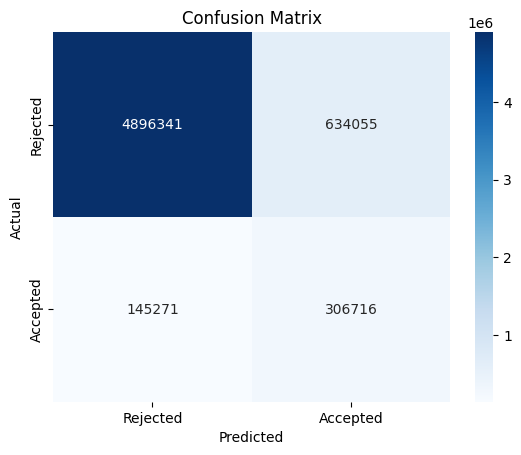

AUC: 0.8638046714885582


0.45163412249580187

In [ ]:
# Add 'class_weight' (10.0/1.0)
model_df = combined_df.withColumn('class_weight', when(col('accepted_flag') == 1, 10.0).otherwise(1.0))

# Split dataset
train_df, test_df = model_df.randomSplit([0.8, 0.2], seed=42)

# Train data
lr = LogisticRegression(featuresCol = 'features',
                        labelCol = 'accepted_flag',
                        weightCol = 'class_weight')

pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

model = pipeline.fit(train_df)

# Predictions
predictions = model.transform(test_df)
predictions.select("accepted_flag", "prediction", "probability").show()

# Classification Report
preds_pd = predictions.select("accepted_flag", "prediction").toPandas()
print(classification_report(preds_pd["accepted_flag"], preds_pd["prediction"], target_names=["Rejected", "Accepted"]))

# Confusion Matrix
cm = confusion_matrix(preds_pd["accepted_flag"], preds_pd["prediction"])
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Rejected", "Accepted"], yticklabels=["Rejected", "Accepted"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# AUC, PR AUC
evaluator = BinaryClassificationEvaluator(labelCol="accepted_flag")
print("AUC:", evaluator.evaluate(predictions))

evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})

+-------------+----------+--------------------+
|accepted_flag|prediction|         probability|
+-------------+----------+--------------------+
|            1|       0.0|[0.50091575577481...|
|            1|       0.0|[0.76578742719080...|
|            1|       1.0|[0.41646576652500...|
|            1|       0.0|[0.66667760495744...|
|            1|       0.0|[0.74486239093091...|
|            1|       0.0|[0.73762574746603...|
|            1|       1.0|[0.44315235584649...|
|            1|       1.0|[0.01982107777168...|
|            1|       1.0|[0.02487900574505...|
|            1|       0.0|[0.73736173847440...|
|            1|       0.0|[0.58900126108980...|
|            1|       0.0|[0.78650826002350...|
|            1|       1.0|[0.09810916075996...|
|            1|       0.0|[0.68688669078815...|
|            1|       0.0|[0.52620627585052...|
|            1|       0.0|[0.60566275470243...|
|            1|       1.0|[0.02527951777563...|
|            1|       1.0|[0.02163355200

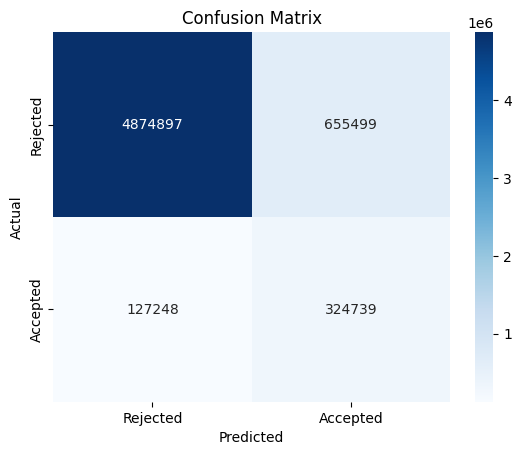

AUC: 0.8638052292402284


0.45138880059644465

In [ ]:
# Add 'class_weight' (12.26/1.0)
model_df = combined_df.withColumn('class_weight', when(col('accepted_flag') == 1, 12.26).otherwise(1.0))

# Split dataset
train_df, test_df = model_df.randomSplit([0.8, 0.2], seed=42)

# Train data
lr = LogisticRegression(featuresCol = 'features',
                        labelCol = 'accepted_flag',
                        weightCol = 'class_weight')

pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

model = pipeline.fit(train_df)

# Predictions
predictions = model.transform(test_df)
predictions.select("accepted_flag", "prediction", "probability").show()

# Classification Report
preds_pd = predictions.select("accepted_flag", "prediction").toPandas()
print(classification_report(preds_pd["accepted_flag"], preds_pd["prediction"], target_names=["Rejected", "Accepted"]))

# Confusion Matrix
cm = confusion_matrix(preds_pd["accepted_flag"], preds_pd["prediction"])
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Rejected", "Accepted"], yticklabels=["Rejected", "Accepted"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# AUC, PR AUC
evaluator = BinaryClassificationEvaluator(labelCol="accepted_flag")
print("AUC:", evaluator.evaluate(predictions))

evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})